In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib
import matplotlib.pyplot as plt

from utils import mnist
import numpy as np

In [2]:
def plot_train_test(logs, tpe='loss'):
    fig=plt.figure(figsize=(18, 9), dpi= 80, facecolor='w', edgecolor='k')
    for log in logs:
        keys = log.keys()
        logs = {k:[z for z in zip(*log[k])] for k in keys}
        epochs = {k:range(len(log[k])) for k in keys}

        if tpe == 'loss':
            handlers, = zip(*[plt.plot(epochs[k], logs[k][0], label=k) for k in keys])
            plt.title('errors')
            plt.xlabel('epoch')
            plt.ylabel('error')

        elif tpe == 'accuracy':
            handlers, = zip(*[plt.plot(epochs[k], logs[k][1], label=k) for k in log.keys()])
            plt.title('accuracy')
            plt.xlabel('epoch')
            plt.ylabel('accuracy')
    plt.legend(handles=handlers)
    plt.show()

In [3]:
train_loader, test_loader = mnist()

In [4]:
class Net(nn.Module):
    def __init__(self, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, 128)
        self.fc5 = nn.Linear(128, 10)
        self.optim = optim.SGD(self.parameters(), lr=1.0)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        x = self.fc4(x)
        x = self.fc5(x)
        x = torch.log_softmax(x, dim=1)
        return x
    
    def loss(self, output, target, **kwargs):
        self._loss = F.nll_loss(output, target, **kwargs)
        return self._loss

In [5]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    train_loss = {k: 0. for k in models}
    correct = {k: 0. for k in models}
    for batch_idx, (data, target) in enumerate(train_loader):
        for k, model in models.items():
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, target)
            train_loss[k] += loss.item() # sum up batch loss
            loss.backward()
            model.optim.step()
            pred = output.data.max(1, keepdim=True)[1]
            correct[k] += pred.eq(target.data.view_as(pred)).cpu().sum().item()
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        print(line + losses)
    for k in models:
        train_loss[k] /= train_size
    correct_pct = {k: 100. * correct[k] / train_size for k in correct}
    if log is not None:
        for k in models:
            log[k].append((train_loss[k], correct_pct[k]))

In [6]:
models = {'default': Net()}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [7]:
def test(models, loader, log=None):
    test_size = len(loader.sampler)
    avg_lambda = lambda l: 'Loss: {:.4f}'.format(l)
    acc_lambda = lambda c, p: 'Accuracy: {}/{} ({:.0f}%)'.format(c, test_size, p)
    line = lambda i, l, c, p: '{}: '.format(i) + avg_lambda(l) + '\t' + acc_lambda(c, p)

    test_loss = {k: 0. for k in models}
    correct = {k: 0. for k in models}
    with torch.no_grad():
        for data, target in loader:
            # output = {k: m(data) for m in models}
            for k, m in models.items():
                output = m(data)
                test_loss[k] += m.loss(output, target, reduction='sum').item() # sum up batch loss
                pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct[k] += pred.eq(target.data.view_as(pred)).cpu().sum().item()
    
    for k in models:
        test_loss[k] /= test_size
    correct_pct = {k: 100. * correct[k] / test_size for k in correct}
    lines = '\n'.join([line(k, test_loss[k], correct[k], correct_pct[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines
    if log is not None:
        for k in models:
            log[k].append((test_loss[k], correct_pct[k]))
    print(report)

In [8]:
for epoch in range(1, 121):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, test_loader, test_log)

Train Epoch: 1 [0/60000 (0%)]	Losses default: 2.325534
Train Epoch: 1 [10000/60000 (17%)]	Losses default: 2.207896
Train Epoch: 1 [20000/60000 (33%)]	Losses default: 1.780091
Train Epoch: 1 [30000/60000 (50%)]	Losses default: 1.278163
Train Epoch: 1 [40000/60000 (67%)]	Losses default: 1.141322
Train Epoch: 1 [50000/60000 (83%)]	Losses default: 1.063944
Train Epoch: 1 [60000/60000 (100%)]	Losses default: 0.574180
Test set:
default: Loss: 0.4855	Accuracy: 8767.0/10000 (88%)

Train Epoch: 2 [0/60000 (0%)]	Losses default: 0.614735
Train Epoch: 2 [10000/60000 (17%)]	Losses default: 0.322942
Train Epoch: 2 [20000/60000 (33%)]	Losses default: 0.175299
Train Epoch: 2 [30000/60000 (50%)]	Losses default: 0.237986
Train Epoch: 2 [40000/60000 (67%)]	Losses default: 0.369279
Train Epoch: 2 [50000/60000 (83%)]	Losses default: 0.881384
Train Epoch: 2 [60000/60000 (100%)]	Losses default: 0.506371
Test set:
default: Loss: 0.3456	Accuracy: 9011.0/10000 (90%)

Train Epoch: 3 [0/60000 (0%)]	Losses default

Train Epoch: 18 [10000/60000 (17%)]	Losses default: 0.000277
Train Epoch: 18 [20000/60000 (33%)]	Losses default: 0.049443
Train Epoch: 18 [30000/60000 (50%)]	Losses default: 0.005340
Train Epoch: 18 [40000/60000 (67%)]	Losses default: 0.005501
Train Epoch: 18 [50000/60000 (83%)]	Losses default: 0.095962
Train Epoch: 18 [60000/60000 (100%)]	Losses default: 0.140320
Test set:
default: Loss: 0.1480	Accuracy: 9636.0/10000 (96%)

Train Epoch: 19 [0/60000 (0%)]	Losses default: 0.195076
Train Epoch: 19 [10000/60000 (17%)]	Losses default: 0.021649
Train Epoch: 19 [20000/60000 (33%)]	Losses default: 0.017696
Train Epoch: 19 [30000/60000 (50%)]	Losses default: 0.050235
Train Epoch: 19 [40000/60000 (67%)]	Losses default: 0.082976
Train Epoch: 19 [50000/60000 (83%)]	Losses default: 0.141594
Train Epoch: 19 [60000/60000 (100%)]	Losses default: 0.000971
Test set:
default: Loss: 0.1207	Accuracy: 9714.0/10000 (97%)

Train Epoch: 20 [0/60000 (0%)]	Losses default: 0.080628
Train Epoch: 20 [10000/60000 (

Train Epoch: 35 [10000/60000 (17%)]	Losses default: 0.030800
Train Epoch: 35 [20000/60000 (33%)]	Losses default: 0.001250
Train Epoch: 35 [30000/60000 (50%)]	Losses default: 0.002617
Train Epoch: 35 [40000/60000 (67%)]	Losses default: 0.001986
Train Epoch: 35 [50000/60000 (83%)]	Losses default: 0.000871
Train Epoch: 35 [60000/60000 (100%)]	Losses default: 0.061265
Test set:
default: Loss: 0.1375	Accuracy: 9687.0/10000 (97%)

Train Epoch: 36 [0/60000 (0%)]	Losses default: 0.007217
Train Epoch: 36 [10000/60000 (17%)]	Losses default: 0.064607
Train Epoch: 36 [20000/60000 (33%)]	Losses default: 0.011686
Train Epoch: 36 [30000/60000 (50%)]	Losses default: 0.102834
Train Epoch: 36 [40000/60000 (67%)]	Losses default: 0.146717
Train Epoch: 36 [50000/60000 (83%)]	Losses default: 0.000251
Train Epoch: 36 [60000/60000 (100%)]	Losses default: 0.015942
Test set:
default: Loss: 0.1369	Accuracy: 9697.0/10000 (97%)

Train Epoch: 37 [0/60000 (0%)]	Losses default: 0.009303
Train Epoch: 37 [10000/60000 (

Train Epoch: 52 [10000/60000 (17%)]	Losses default: 0.001807
Train Epoch: 52 [20000/60000 (33%)]	Losses default: 0.009761
Train Epoch: 52 [30000/60000 (50%)]	Losses default: 0.007142
Train Epoch: 52 [40000/60000 (67%)]	Losses default: 0.000445
Train Epoch: 52 [50000/60000 (83%)]	Losses default: 0.003165
Train Epoch: 52 [60000/60000 (100%)]	Losses default: 0.000581
Test set:
default: Loss: 0.1531	Accuracy: 9733.0/10000 (97%)

Train Epoch: 53 [0/60000 (0%)]	Losses default: 0.000496
Train Epoch: 53 [10000/60000 (17%)]	Losses default: 0.001525
Train Epoch: 53 [20000/60000 (33%)]	Losses default: 0.000826
Train Epoch: 53 [30000/60000 (50%)]	Losses default: 0.001048
Train Epoch: 53 [40000/60000 (67%)]	Losses default: 0.000641
Train Epoch: 53 [50000/60000 (83%)]	Losses default: 0.002793
Train Epoch: 53 [60000/60000 (100%)]	Losses default: 0.018588
Test set:
default: Loss: 0.1595	Accuracy: 9730.0/10000 (97%)

Train Epoch: 54 [0/60000 (0%)]	Losses default: 0.001226
Train Epoch: 54 [10000/60000 (

Train Epoch: 69 [10000/60000 (17%)]	Losses default: 0.004095
Train Epoch: 69 [20000/60000 (33%)]	Losses default: 0.002661
Train Epoch: 69 [30000/60000 (50%)]	Losses default: 0.001830
Train Epoch: 69 [40000/60000 (67%)]	Losses default: 0.000066
Train Epoch: 69 [50000/60000 (83%)]	Losses default: 0.000043
Train Epoch: 69 [60000/60000 (100%)]	Losses default: 0.000068
Test set:
default: Loss: 0.1576	Accuracy: 9741.0/10000 (97%)

Train Epoch: 70 [0/60000 (0%)]	Losses default: 0.001909
Train Epoch: 70 [10000/60000 (17%)]	Losses default: 0.004757
Train Epoch: 70 [20000/60000 (33%)]	Losses default: 0.000585
Train Epoch: 70 [30000/60000 (50%)]	Losses default: 0.000113
Train Epoch: 70 [40000/60000 (67%)]	Losses default: 0.000170
Train Epoch: 70 [50000/60000 (83%)]	Losses default: 0.005888
Train Epoch: 70 [60000/60000 (100%)]	Losses default: 0.100694
Test set:
default: Loss: 0.1573	Accuracy: 9741.0/10000 (97%)

Train Epoch: 71 [0/60000 (0%)]	Losses default: 0.000109
Train Epoch: 71 [10000/60000 (

Train Epoch: 86 [10000/60000 (17%)]	Losses default: 0.000042
Train Epoch: 86 [20000/60000 (33%)]	Losses default: 0.000388
Train Epoch: 86 [30000/60000 (50%)]	Losses default: 0.000055
Train Epoch: 86 [40000/60000 (67%)]	Losses default: 0.000397
Train Epoch: 86 [50000/60000 (83%)]	Losses default: 0.000079
Train Epoch: 86 [60000/60000 (100%)]	Losses default: 0.000054
Test set:
default: Loss: 0.1640	Accuracy: 9748.0/10000 (97%)

Train Epoch: 87 [0/60000 (0%)]	Losses default: 0.000027
Train Epoch: 87 [10000/60000 (17%)]	Losses default: 0.040707
Train Epoch: 87 [20000/60000 (33%)]	Losses default: 0.000082
Train Epoch: 87 [30000/60000 (50%)]	Losses default: 0.000114
Train Epoch: 87 [40000/60000 (67%)]	Losses default: 0.029247
Train Epoch: 87 [50000/60000 (83%)]	Losses default: 0.002687
Train Epoch: 87 [60000/60000 (100%)]	Losses default: 0.000386
Test set:
default: Loss: 0.1469	Accuracy: 9760.0/10000 (98%)

Train Epoch: 88 [0/60000 (0%)]	Losses default: 0.000404
Train Epoch: 88 [10000/60000 (

Train Epoch: 103 [10000/60000 (17%)]	Losses default: 0.000032
Train Epoch: 103 [20000/60000 (33%)]	Losses default: 0.002047
Train Epoch: 103 [30000/60000 (50%)]	Losses default: 0.000178
Train Epoch: 103 [40000/60000 (67%)]	Losses default: 0.000036
Train Epoch: 103 [50000/60000 (83%)]	Losses default: 0.000964
Train Epoch: 103 [60000/60000 (100%)]	Losses default: 0.000088
Test set:
default: Loss: 0.1593	Accuracy: 9733.0/10000 (97%)

Train Epoch: 104 [0/60000 (0%)]	Losses default: 0.000595
Train Epoch: 104 [10000/60000 (17%)]	Losses default: 0.000161
Train Epoch: 104 [20000/60000 (33%)]	Losses default: 0.000203
Train Epoch: 104 [30000/60000 (50%)]	Losses default: 0.000394
Train Epoch: 104 [40000/60000 (67%)]	Losses default: 0.000226
Train Epoch: 104 [50000/60000 (83%)]	Losses default: 0.000732
Train Epoch: 104 [60000/60000 (100%)]	Losses default: 0.001072
Test set:
default: Loss: 0.1633	Accuracy: 9724.0/10000 (97%)

Train Epoch: 105 [0/60000 (0%)]	Losses default: 0.000044
Train Epoch: 105

Test set:
default: Loss: 0.1678	Accuracy: 9754.0/10000 (98%)

Train Epoch: 120 [0/60000 (0%)]	Losses default: 0.000018
Train Epoch: 120 [10000/60000 (17%)]	Losses default: 0.000002
Train Epoch: 120 [20000/60000 (33%)]	Losses default: 0.000023
Train Epoch: 120 [30000/60000 (50%)]	Losses default: 0.000019
Train Epoch: 120 [40000/60000 (67%)]	Losses default: 0.000006
Train Epoch: 120 [50000/60000 (83%)]	Losses default: 0.000009
Train Epoch: 120 [60000/60000 (100%)]	Losses default: 0.000002
Test set:
default: Loss: 0.1692	Accuracy: 9754.0/10000 (98%)



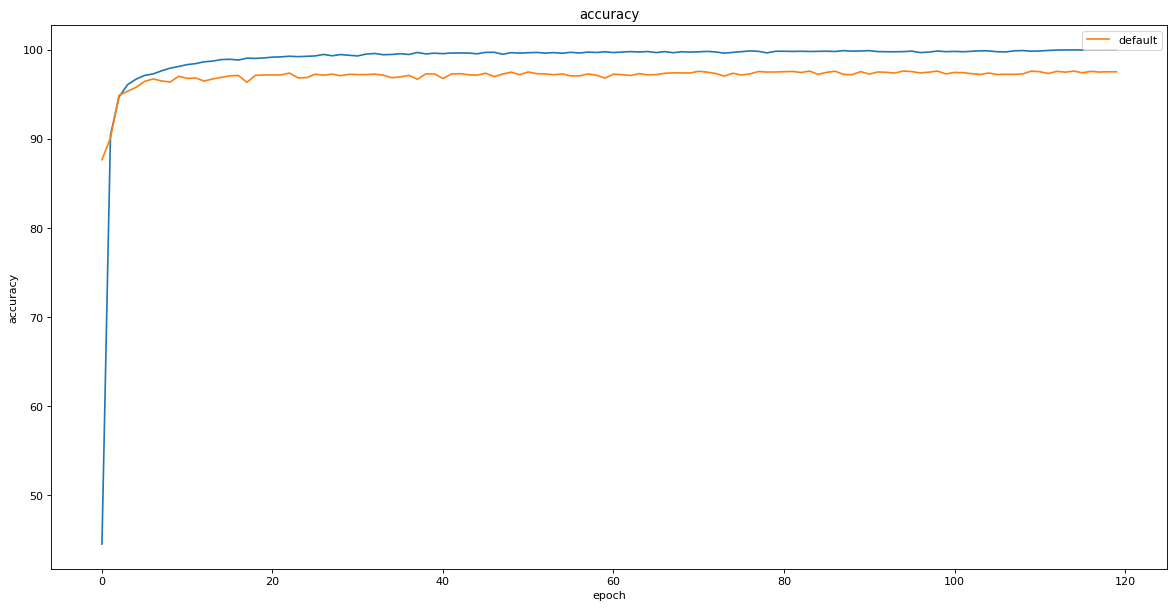

In [9]:
plot_train_test([train_log, test_log], 'accuracy')